This notebook is created for mining multi-folder structured dataset of enron downloaded from https://www.cs.cmu.edu/~enron/. 
Tasks that are performed for preprocessing and analysis are bolow-
* <b>Prelimnary data exploration</b>
* Selection of data for analysis, its structuring, including new columns
* <b>Data visualizations</b> to see some direct patterns from data
* <b>Data Cleaning and compression</b>: Duplicate email detection, Alias/Fake user identity identification
* <b>Email network graph creation</b> - On sent emails: where nodes are unique users(aggregated different identities by a user) and an edge is communication made between two such users.
* <b>Network graph analysis and visualizations</b> to analyze various communication links between users (employees and non-employees)
* <b>Topic Analysis </b> from contents of emails

In [346]:
import pandas as pd
import email
import os
import collections
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

# NLP
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
import re

In [ ]:
root_dir = 'maildir'
#  for initail subset data exploration
data_dir = root_dir+ '/allen-p/' 
sent_mail_dir = data_dir + '/'+ '_sent_mail'
sent_dir = data_dir + '/'+ 'sent'
sent_items_dir = data_dir + '/'+ 'sent_items'


In [118]:
# Getting a parsed email object from email file
def get_message_object(message_file):
    with open(message_file, 'r') as fr:
        message = email.message_from_file(fr)
    return message   

In [119]:
sentmail_messages =  [get_message_object(sent_mail_dir+'/'+message_file) for message_file in os.listdir(sent_mail_dir)]
sent_messages = [get_message_object(sent_dir+'/'+message_file) for message_file in os.listdir(sent_dir)]
sentitem_messages = [get_message_object(sent_items_dir+'/'+message_file) for message_file in os.listdir(sent_items_dir)]

In [120]:
# extracting various fields present in message object
def get_extracted_fields(message,mappings):
    for field in message.keys():
        mappings[field].append(message[field])
    if message.get_content_type() == 'text/plain':
        mappings['content'].append(message.get_payload())
    return mappings

In [121]:
# Extract various fields from sent folders of user 'allen-p'
sentmail_map = collections.defaultdict(list)
sent_map = collections.defaultdict(list)
sentitem_map = collections.defaultdict(list)
for message in sentmail_messages:
    sentmail_map = get_extracted_fields(message,sentmail_map)
for message in sent_messages:
    sent_map = get_extracted_fields(message,sent_map)
for message in sentitem_messages:
    sentitem_map = get_extracted_fields(message,sentitem_map)

In [39]:
sentmail_map.keys()

['Cc',
 'X-cc',
 'From',
 'Subject',
 'X-Folder',
 'Content-Transfer-Encoding',
 'X-bcc',
 'Bcc',
 'content',
 'To',
 'X-Origin',
 'X-FileName',
 'X-From',
 'Date',
 'X-To',
 'Message-ID',
 'Content-Type',
 'Mime-Version']

### Understand use of various identities used by user 'allen-p' while sending emails

In [399]:
print set(sentmail_map['From'])
print set(sent_map['From'])
print set(sentitem_map['From'])

set(['phillip.allen@enron.com', 'ina.rangel@enron.com'])
set(['phillip.allen@enron.com', 'ina.rangel@enron.com'])
set(['phillip.allen@enron.com', 'pam.butler@enron.com', 'k..allen@enron.com'])


In [36]:
print set(sentmail_map['X-From'])
print set(sent_map['X-From'])
print set(sentitem_map['X-From'])

set(['Phillip K Allen', 'Ina Rangel'])
set(['Phillip K Allen', 'Ina Rangel'])
set(['Butler, Pam </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PBUTLER>', 'Phillip K Allen', 'Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PALLEN>'])


In [37]:
print set(sentmail_map['X-Origin'])
print set(sent_map['X-Origin'])
print set(sentitem_map['X-Origin'])

set(['Allen-P'])
set(['Allen-P'])
set(['Allen-P'])


In [56]:
print set(sentmail_map['X-FileName'])
print set(sent_map['X-FileName'])
print set(sentitem_map['X-FileName'])

set(['pallen (Non-Privileged).pst', 'pallen.nsf'])
set(['pallen.nsf'])
set(['pallen (Non-Privileged).pst', 'PALLEN (Non-Privileged).pst'])


### Identify presence of duplicate email files(with different filenames, messageid) in various sent folders

In [122]:
# check duplicacy
sent_unique = 0
for content in sent_map['content']:
    if content not in sentmail_map['content']:
        sent_unique += 1

print 'Total:',len(sent_map['Message-ID']), ' Unique:',sent_unique

sentitem_unique = 0
for content in sentitem_map['content']:
    if content not in sentmail_map['content']:
        sentitem_unique += 1

print 'Total:',len(sentitem_map['Message-ID']), ' Unique:',sentitem_unique

Total: 1124  Unique: 0
Total: 690  Unique: 596


In [44]:
len(sentmail_map['Message-ID']),len(sent_map['Message-ID'])

(1204, 1124)

In [48]:
print len(set(sentmail_map['X-To']))
print len(set(sent_map['X-To']))
print len(set(sentitem_map['X-To']))

264
233
178


### Data Selection/Structuring/Preprocessing on full corpus
* Functions used while training dataframe creation.
* Steps performed: Email Files selection, duplicate email removal, Field Extraction, Additional fields insertion
* Extraction of all users and their identities
* Identification of identities used by more than one user source

In [270]:
%%time
# extracting duplicate emails by content match
def is_duplicate_email(email_object, user_email_df):
    if email_object.get_content_type()=='text/plain':
        exisiting_mails = set(user_email_df['content'])
        content = email_object.get_payload()
        if content in exisiting_mails:
            #print 'Found duplicate email:',email_object
            #index =  exisiting_mails.index(content)
            #print index,'\n',user_email_df.loc[index]
            return True
    else:
        print 'Different content type exist:',email_object.get_content_type()
    return False

Wall time: 0 ns


In [114]:
# insert additional fields/features/columns to dataframe
def insert_fields(email_object, user, user_email_df):
    email_object['content'] = email_object.get_payload()
    email_object['user'] = user
    existing_labels = set(email_object.keys())
        
    index = len(user_email_df)
    user_email_df.loc[index] = [None]*len(user_email_df.columns)
    
    for lbl in labels:
        user_email_df.loc[index][lbl] = email_object[lbl] 
        #print lbl, ':', email_object[lbl] 
    return user_email_df

# Test
#user_message_df = pd.DataFrame(columns=labels)
#user_message_df = insert_fields(sent_emails[0],'allen',user_message_df)
#insert_fields(sent_emails[1],'allen',user_message_df)
#sent_emails

In [135]:
def extract_identities(user_message_df):
    identities = set()
    identities.update(list(user_message_df['From']))
    identities.update(list(user_message_df['X-Origin']))
    identities.update(list(user_message_df['X-From']))
    return identities

In [72]:
labels = sentmail_map.keys()
# Remove unimporatant fields
for remove_lbl in ['Content-Transfer-Encoding','Content-Type','Mime-Version']:
    labels.remove(remove_lbl)
labels.append('user')
labels

['Cc',
 'X-cc',
 'From',
 'Subject',
 'X-Folder',
 'X-bcc',
 'Bcc',
 'content',
 'To',
 'X-Origin',
 'X-FileName',
 'X-From',
 'Date',
 'X-To',
 'Message-ID',
 'user']

In [155]:
%%time
def get_sent_emails(user,user_message_df):
    #user_message_df = pd.DataFrame(columns=labels)
    sent_folders = ['_sent_mail','sent','sent_items']
    print '\n\nuser:',user
    unique_cnt = 0
    for sent_folder in sent_folders:
        mail_folder = root_dir + '/' + user + '/' + sent_folder
        if not os.path.isdir(mail_folder):
            continue
            
        print sent_folder, ':', len(os.listdir(mail_folder))
        for (dirpath, dirnames, filenames) in os.walk(mail_folder):
            sent_emails = [get_message_object(dirpath+'/'+filename) for filename in filenames]
            for email_obj in sent_emails:
                if not is_duplicate_email(email_obj,user_message_df):
                    user_message_df = insert_fields(email_obj,user,user_message_df)
                    unique_cnt += 1

    print 'Total unique:',unique_cnt
    return user_message_df

user = 'allen-p'
user_message_df = pd.DataFrame(columns=labels)
sent_emails = get_sent_emails(user,user_message_df)




user: allen-p
_sent_mail : 1204
sent : 1124
sent_items : 690
Total unique: 900
Wall time: 8.87 s


In [116]:
1204+1124

3018

In [271]:
# extract all identities of user
user_message_df = pd.DataFrame(columns=labels)

identity_user_map = collections.defaultdict(set)
user_identity_map = dict()

for user in os.listdir(root_dir):
    user_message_df = get_sent_emails(user,user_message_df)
    
    identities = extract_identities(user_message_df[user_message_df['user']==user])
    user_identity_map[user] = identities
    for identity in identities:
        # check exisiting duplicate identity
        if identity in identity_user_map:
            print 'Found duplicate identity:',identity, ' with user(s):',identity_user_map[identity]
        identity_user_map[identity].add(user)



user: allen-p
_sent_mail : 1204
sent : 1124
sent_items : 690
Total unique: 900


user: arnold-j
_sent_mail : 1628
sent : 1632
sent_items : 1446
Total unique: 1523


user: arora-h
_sent_mail : 180
sent : 18
sent_items : 136
Total unique: 164


user: badeer-r
_sent_mail : 104
sent_items : 14
Total unique: 59


user: bailey-s
sent_items : 28
Total unique: 14


user: bass-e
_sent_mail : 2818
sent : 2726
sent_items : 516
Total unique: 1666


user: baughman-d
sent_items : 192
Total unique: 96


user: beck-s
_sent_mail : 2186
sent : 2198
sent_items : 964
Total unique: 1581


user: benson-r
_sent_mail : 18
sent : 14
sent_items : 32
Total unique: 23


user: blair-l
_sent_mail : 78
sent_items : 1858
Total unique: 929


user: brawner-s
_sent_mail : 290
sent : 260
sent_items : 146
Total unique: 200


user: buy-r
_sent_mail : 330
sent : 358
sent_items : 780
Total unique: 554


user: campbell-l
_sent_mail : 400
sent : 700
sent_items : 234
Total unique: 468


user: carson-m
_sent_mail : 344
sent : 

sent : 136
sent_items : 12
Total unique: 73


user: quigley-d
sent_items : 1012
Total unique: 501
Found duplicate identity: no.address@enron.com  with user(s): set(['maggi-m', 'forney-j', 'lenhart-m', 'brawner-s', 'mckay-j', 'may-l', 'hodge-j', 'germany-c', 'presto-k'])
Found duplicate identity: @ECT  with user(s): set(['lenhart-m', 'brawner-s', 'mckay-j', 'germany-c', 'presto-k'])


user: rapp-b
sent_items : 208
Total unique: 104


user: reitmeyer-j
sent_items : 114
Total unique: 57


user: richey-c
_sent_mail : 200
sent_items : 498
Total unique: 348


user: ring-a
_sent_mail : 254
sent : 226
sent_items : 56
Total unique: 155


user: ring-r
sent_items : 102
Total unique: 51


user: rodrique-r
_sent_mail : 1442
sent : 1442
Total unique: 718


user: rogers-b
_sent_mail : 1730
sent : 1732
sent_items : 180
Total unique: 954


user: ruscitti-k
_sent_mail : 350
sent : 310
sent_items : 146
Total unique: 222


user: sager-e
sent : 2122
sent_items : 830
Total unique: 1451


user: saibi-e
sent_

In [410]:
# identify multiple email address present in address fields
def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

address_fields = ['Cc', 'X-cc','X-bcc', 'Bcc','X-To','X-From','X-Origin', 'To', 'From']

for col in address_fields:
        user_message_df[col] = user_message_df[col].map(split_email_addresses)
        
# datatype check
user_message_df['Date'] = pd.to_datetime(user_message_df['Date'], infer_datetime_format=True)

In [409]:
user_message_df.columns

Index([u'Cc', u'X-cc', u'From', u'Subject', u'X-Folder', u'X-bcc', u'Bcc',
       u'content', u'To', u'X-Origin', u'X-FileName', u'X-From', u'Date',
       u'X-To', u'Message-ID', u'user'],
      dtype='object')

## Exploratory Analysis

### When do people send most emails
and we find <b>2001 is the year peak of communications was acheived and then it dropped down.
This finding we'll use in further analysis.</b>

Text(0,0.5,u'N emails')

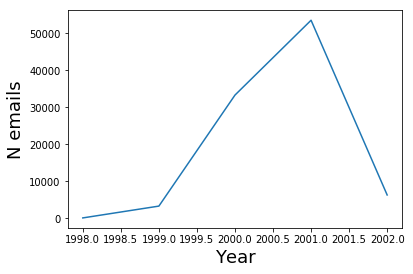

In [274]:
ax = user_message_df.groupby(user_message_df['Date'].dt.year)['content'].count().plot()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)


Text(0,0.5,u'N emails')

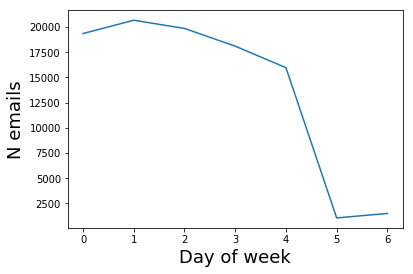

In [401]:
ax = emails_df.groupby(emails_df['Date'].dt.dayofweek)['content'].count().plot()
ax.set_xlabel('Day of week', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

Text(0,0.5,u'N emails')

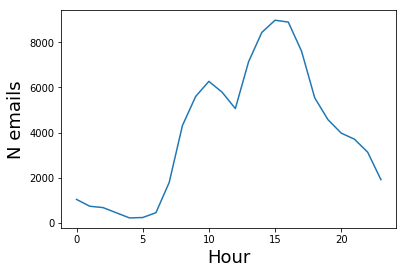

In [402]:
ax = emails_df.groupby(emails_df['Date'].dt.hour)['content'].count().plot()
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

## Who sends most emails

Text(0,0.5,u'N emails')

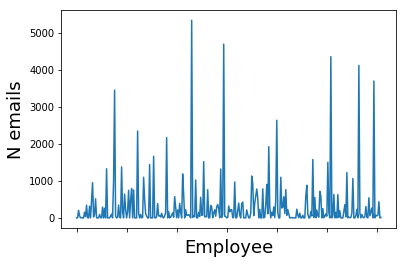

In [400]:
ax = emails_df.groupby(emails_df['From'])['content'].count()
ax=ax.plot()
ax.set_xticklabels([])
ax.set_xlabel('Employee', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

## Social network analyses of email senders and recipients¶

In [413]:
# get user name for receiving email ids
def get_receiving_usernames(df, row_index):
    receiving_cols = ['Cc', 'X-cc','X-bcc', u'Bcc','X-To','To']
    receiving_users = set()
    for col in receiving_cols:
        ids = df.loc[row_index][col]
        if not ids:
            continue
        #ids = split_email_addresses(ids)#ids.split(',')
        for identity in ids:
            if not identity:
                continue
            if identity in identity_user_map:
                if len(identity_user_map[identity])==1:
                    receiving_users.add(list(identity_user_map[identity])[0])
                else:
                    receiving_users.add(identity)
                    #print 'Identity used by more than one user:',identity
            else:
                receiving_users.add(identity)
                #print 'Identity not found in user groups:',identity
    
    return receiving_users

get_receiving_usernames(user_message_df,0)
#user_message_df['To']

Tim Belden <Tim Belden/Enron@EnronXGate>
tim.belden@enron.com


{'Tim Belden <Tim Belden/Enron@EnronXGate>', 'tim.belden@enron.com'}

In [375]:
def get_connections(emails_df):
    for index in emails_df.index:
        user = emails_df.loc[index]['user']
        receiving_users = get_receiving_usernames(emails_df, index)
        if len(receiving_users) >0:
            yield [(user,rec_user) for rec_user in receiving_users][0]

for con in get_connections(user_message_df):
    print con
    break

('allen-p', 'tim.belden@enron.com')


In [277]:
# identity used by multiple users
for identity in identity_user_map.keys():
    if len(identity_user_map[identity])>1:
        print identity, ':', identity_user_map[identity]

louise.kitchen@enron.com : set(['presto-k', 'kitchen-l'])
Greg Whalley : set(['whalley-g', 'whalley-l'])
@ENRON : set(['ybarbo-p', 'hodge-j'])
@ECT : set(['lenhart-m', 'brawner-s', 'mckay-j', 'scott-s', 'tholt-j', 'germany-c', 'presto-k', 'quigley-d'])
Shankman-J : set(['king-j', 'shankman-j', 'dasovich-j'])
Sager, Elizabeth </O=ENRON/OU=NA/CN=RECIPIENTS/CN=ESAGER> : set(['sager-e', 'steffes-j'])
Tamara Jae Black : set(['presto-k', 'sturm-f'])
Dasovich-J : set(['shankman-j', 'dasovich-j'])
tamara.black@enron.com : set(['presto-k', 'sturm-f'])
liz.taylor@enron.com : set(['whalley-g', 'whalley-l'])
elizabeth.sager@enron.com : set(['sager-e', 'steffes-j'])
40enron@enron.com : set(['presto-k', 'arora-h'])
pam.butler@enron.com : set(['neal-s', 'allen-p'])
Panus, Stephanie </O=ENRON/OU=NA/CN=RECIPIENTS/CN=SPANUS> : set(['phanis-s', 'panus-s'])
Butler, Pam </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PBUTLER> : set(['neal-s', 'allen-p'])
no.address@enron.com : set(['maggi-m', 'white-s', 'ybarbo-p', 'forn

## Create Network(directed graph) of sent emails

In [377]:
cnter = 0
communication_graph = nx.DiGraph()
emails_df = user_message_df[:]

for sender,receiver in get_connections(emails_df):
    edge_weight,outdegree,indegree = 1,1,1
    sender_indegree,receiver_outdegree = 0,0
    
    if sender in communication_graph.nodes:
        outdegree += communication_graph.nodes[sender]['outdegree']
        sender_indegree = communication_graph.nodes[sender]['indegree']
        
    if receiver in communication_graph.nodes:
        indegree += communication_graph.nodes[receiver]['indegree']
        receiver_outdegree = communication_graph.nodes[receiver]['outdegree']
    
    communication_graph.add_node(sender,outdegree=outdegree,indegree=sender_indegree)
    communication_graph.add_node(receiver,outdegree=receiver_outdegree,indegree=indegree)
    
    if (sender,receiver) in communication_graph.edges:
        edge_weight += communication_graph.get_edge_data(sender,receiver)['count']
    
    # Remove self-loops
    if sender!=receiver:
        communication_graph.add_edge(sender,receiver, count=edge_weight)
    
    cnter += 1
    

Cc                                                         None
X-cc                                                           
From                                    jeff.dasovich@enron.com
Subject       Meet to discuss CFEE's "Regulation 101" for le...
X-Folder              \Jeff_Dasovich_Dec2000\Notes Folders\Sent
X-bcc                                                          
Bcc                                                        None
content       Mona suggested that it would be a good idea to...
To                                                         None
X-Origin                                             DASOVICH-J
X-FileName                                         jdasovic.nsf
X-From                                            Jeff Dasovich
Date                                        1999-12-03 18:27:00
X-To                                                           
Message-ID         <1618141.1075843184332.JavaMail.evans@thyme>
user                                    

Cc                                                     None
X-cc                                                       
From                             maureen.mcvicker@enron.com
Subject                             Lunch w/ Steve K & Hamd
X-Folder          \Steven_Kean_Dec2000_1\Notes Folders\Sent
X-bcc                                                      
Bcc                                                    None
content                             Lunch w/ Steve K & Hamd
To                                                     None
X-Origin                                             KEAN-S
X-FileName                                        skean.nsf
X-From                                     Maureen McVicker
Date                                    2000-09-18 10:47:00
X-To                                                       
Message-ID    <22461969.1075846381180.JavaMail.evans@thyme>
user                                                 kean-s
Name: 43527, dtype: object
Cc           

In [380]:
communication_graph.node['allen-p']

{'indegree': 296, 'outdegree': 853}

## Top 50 communications

In [382]:
for a, b, data in sorted(communication_graph.edges(data=True), key=lambda x: x[2]['count'], reverse=True)[:50]:
    print('{a} {b} {w}'.format(a=a, b=b, w=data['count']))

kaminski-v vkaminski@aol.com 1032
dasovich-j susan.mara@enron.com 536
kaminski-v 'vkaminski@aol.com' 519
mann-k Suzanne Adams 422
mann-k nmann@erac.com 289
mann-k kathleen.carnahan@enron.com 282
jones-t dickson-s 262
kaminski-v Shirley Crenshaw 258
shankman-j jennifer.burns@enron.com 247
dasovich-j paul.kaufman@enron.com 239
mann-k roseann.engeldorf@enron.com 233
rodrique-r Gabriel Monroy 230
symes-k evelyn.metoyer@enron.com 228
kaminski-v stinson.gibner@enron.com 223
lenhart-m mmmarcantel@equiva.com 223
symes-k kerri.thompson@enron.com 216
jones-t taylor-m 207
bass-e shanna.husser@enron.com 177
shackleton-s taylor-m 171
mann-k Carlos Sole 167
germany-c scott.goodell@enron.com 151
dasovich-j Harry Kingerski 141
shackleton-s stephanie.panus@enron.com 140
jones-t Stephanie Sever 140
mann-k sheila.tweed@enron.com 137
lenhart-m shirley.s.elliott@citicorp.com @ ENRON 137
perlingiere-d Russell Diamond 135
lenhart-m 'Erin Richardson <erichardson@sarofim.com>@ENRON' 135
schoolcraft-d controlle

## Top 20 senders

In [394]:
sorted(communication_graph.nodes(data=True), key=lambda x: x[1]['outdegree'],reverse=True)[:20]

[('dasovich-j', {'indegree': 172, 'outdegree': 5217}),
 ('mann-k', {'indegree': 41, 'outdegree': 4686}),
 ('shackleton-s', {'indegree': 442, 'outdegree': 4217}),
 ('kaminski-v', {'indegree': 941, 'outdegree': 4214}),
 ('jones-t', {'indegree': 178, 'outdegree': 4118}),
 ('germany-c', {'indegree': 27, 'outdegree': 3440}),
 ('lenhart-m', {'indegree': 95, 'outdegree': 2627}),
 ('taylor-m', {'indegree': 545, 'outdegree': 2374}),
 ('perlingiere-d', {'indegree': 69, 'outdegree': 2338}),
 ('nemec-g', {'indegree': 28, 'outdegree': 2167}),
 ('sanders-r', {'indegree': 91, 'outdegree': 1991}),
 ('bass-e', {'indegree': 74, 'outdegree': 1664}),
 ('scott-s', {'indegree': 88, 'outdegree': 1606}),
 ('kean-s', {'indegree': 238, 'outdegree': 1570}),
 ('arnold-j', {'indegree': 67, 'outdegree': 1513}),
 ('love-p', {'indegree': 78, 'outdegree': 1473}),
 ('beck-s', {'indegree': 137, 'outdegree': 1455}),
 ('steffes-j', {'indegree': 2, 'outdegree': 1378}),
 ('stclair-c', {'indegree': 302, 'outdegree': 1328}),


## Top 20 receivers

In [395]:
sorted(communication_graph.nodes(data=True), key=lambda x: x[1]['indegree'],reverse=True)[:20]

[('vkaminski@aol.com', {'indegree': 1032, 'outdegree': 0}),
 ('kaminski-v', {'indegree': 941, 'outdegree': 4214}),
 ('susan.mara@enron.com', {'indegree': 639, 'outdegree': 0}),
 ('Suzanne Adams', {'indegree': 552, 'outdegree': 0}),
 ('taylor-m', {'indegree': 545, 'outdegree': 2374}),
 ("'vkaminski@aol.com'", {'indegree': 519, 'outdegree': 0}),
 ('shackleton-s', {'indegree': 442, 'outdegree': 4217}),
 ('dickson-s', {'indegree': 427, 'outdegree': 185}),
 ('haedicke-m', {'indegree': 309, 'outdegree': 995}),
 ('stclair-c', {'indegree': 302, 'outdegree': 1328}),
 ('allen-p', {'indegree': 296, 'outdegree': 853}),
 ('nmann@erac.com', {'indegree': 289, 'outdegree': 0}),
 ('kathleen.carnahan@enron.com', {'indegree': 282, 'outdegree': 0}),
 ('jennifer.burns@enron.com', {'indegree': 275, 'outdegree': 0}),
 ('paul.kaufman@enron.com', {'indegree': 272, 'outdegree': 0}),
 ('susan.flynn@enron.com', {'indegree': 269, 'outdegree': 0}),
 ('lavorato-j', {'indegree': 264, 'outdegree': 1119}),
 ('Shirley C

## Draw the network

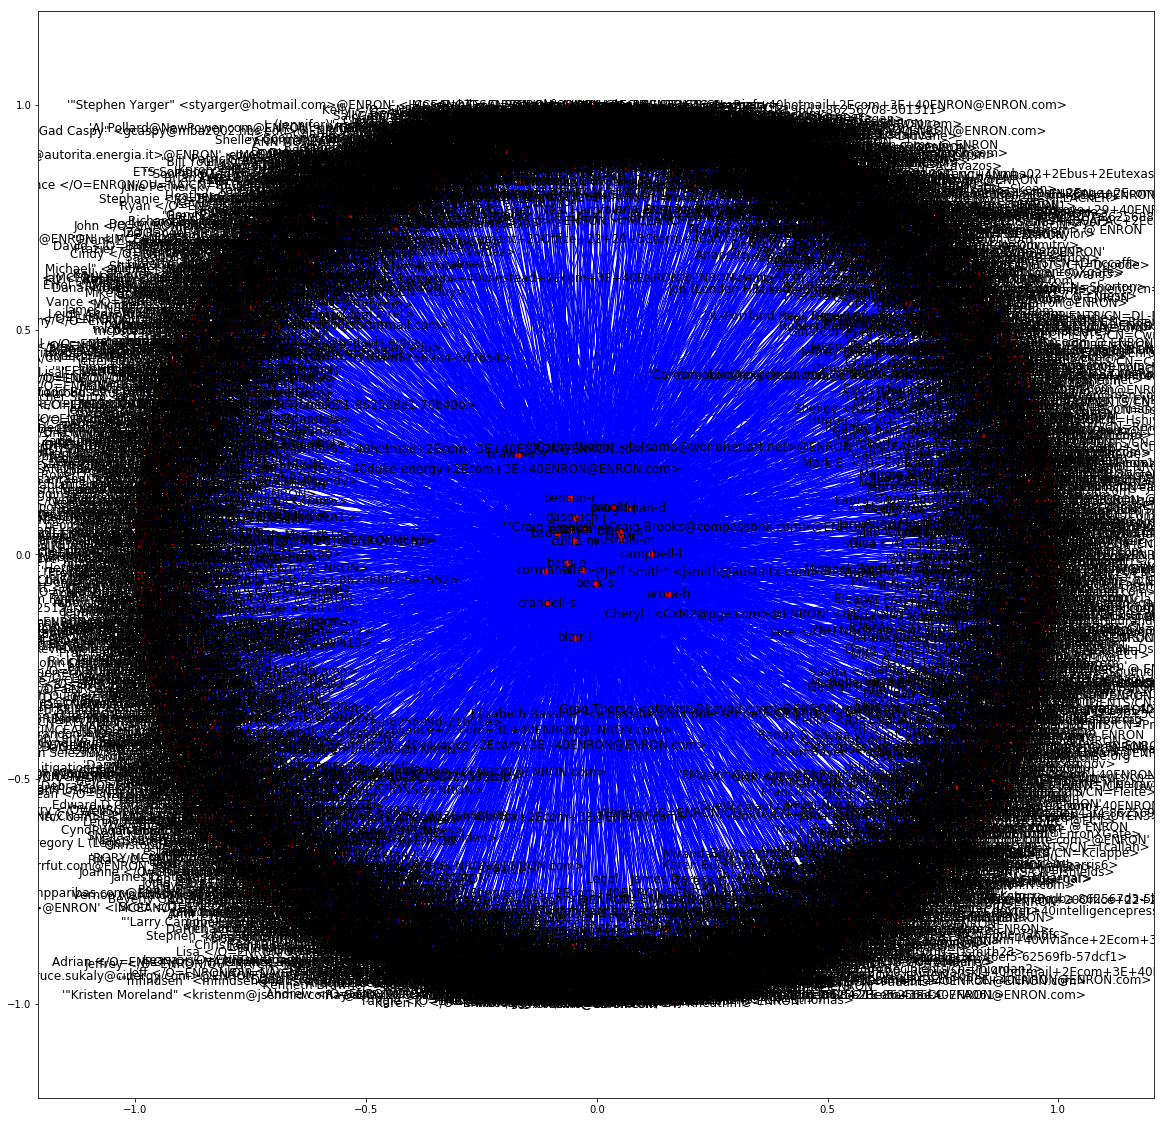

In [298]:
plt.figure(figsize=(20,20))
pos = nx.spring_layout(communication_graph, k=.1)
nx.draw_networkx(communication_graph, pos, node_size=25, node_color='red', with_labels=True, edge_color='blue')
plt.show()

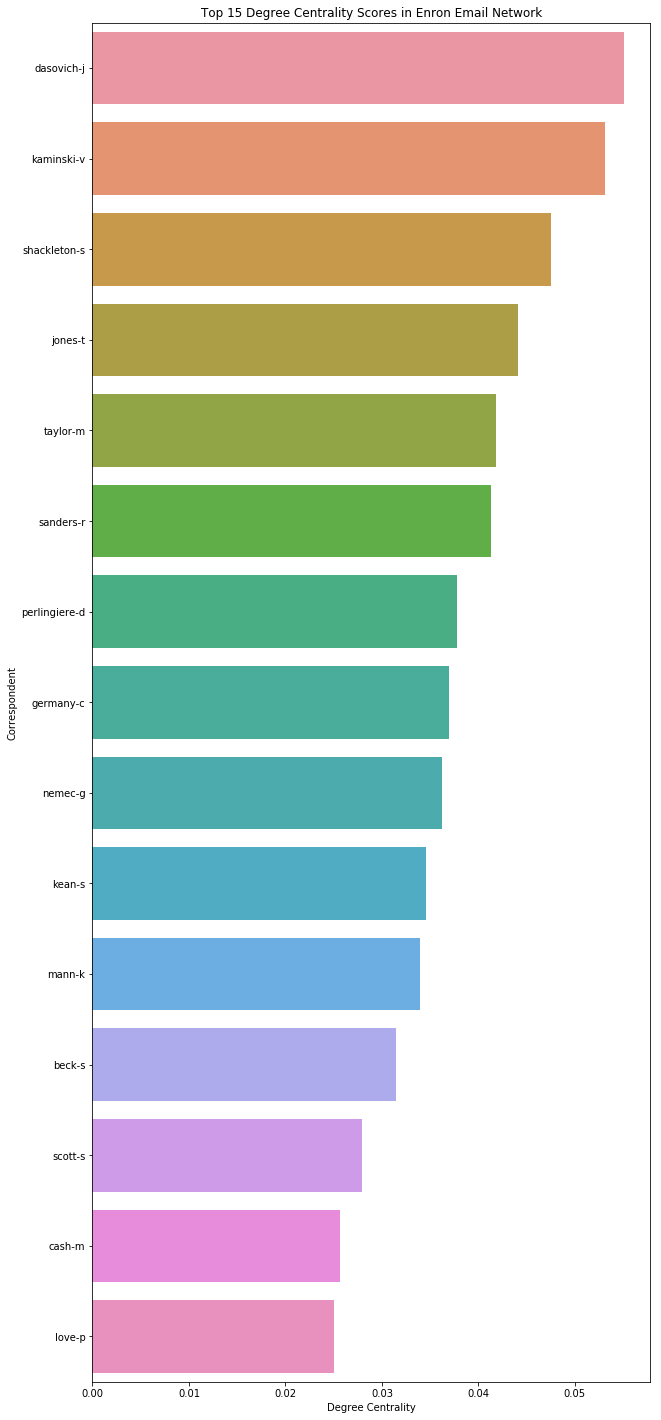

In [396]:
cent = nx.degree_centrality(communication_graph)
name = []
centrality = []

for key, value in cent.items():
    name.append(key)
    centrality.append(value)

cent = pd.DataFrame()    
cent['name'] = name
cent['centrality'] = centrality
cent = cent.sort_values(by='centrality', ascending=False)

plt.figure(figsize=(10, 25))
_ = sns.barplot(x='centrality', y='name', data=cent[:15], orient='h')
_ = plt.xlabel('Degree Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Degree Centrality Scores in Enron Email Network')
plt.show()

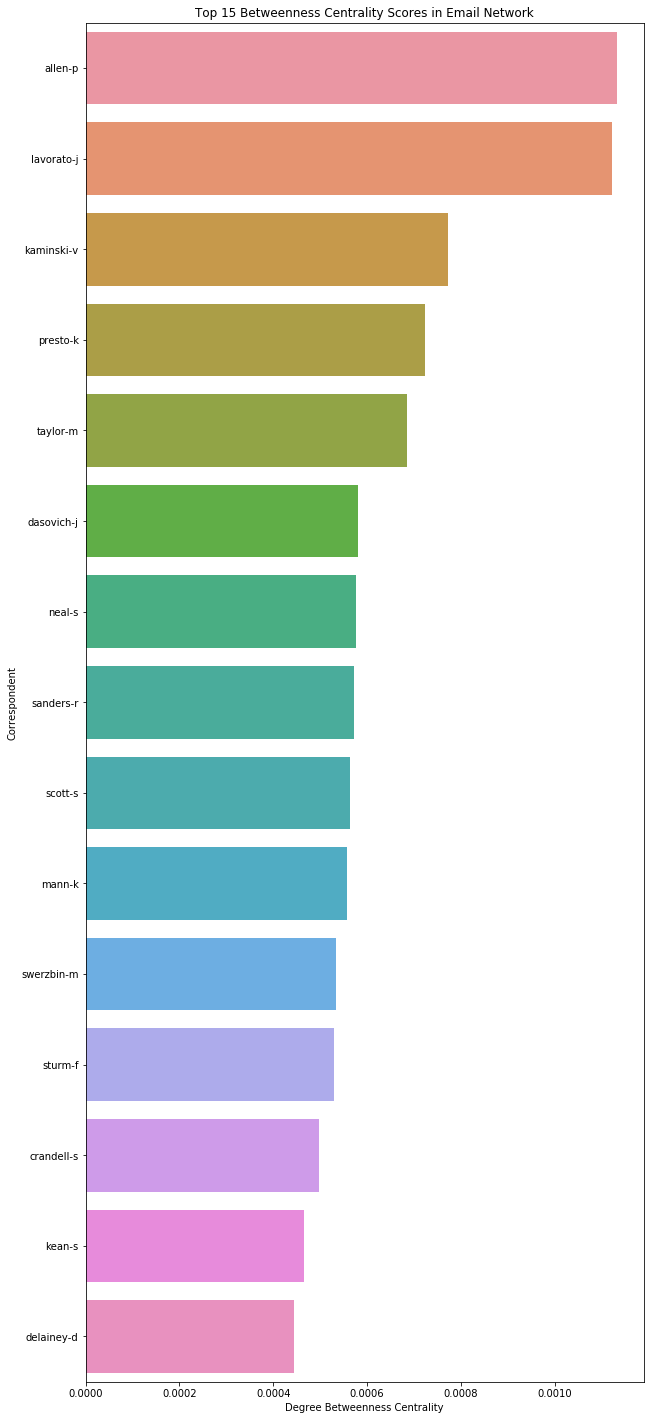

In [397]:
between_nodes = nx.betweenness_centrality(communication_graph)
nodes = []
betweenness = []

for key, value in between_nodes.items():
    nodes.append(key)
    betweenness.append(value)

between_df = pd.DataFrame()
between_df['name'] = nodes
between_df['betweenness'] = betweenness
between_df = between_df.sort_values(by='betweenness', ascending=False)

plt.figure(figsize=(10, 25))
_ = sns.barplot(x='betweenness', y='name', data=between_df[:15], orient='h')
_ = plt.xlabel('Degree Betweenness Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Betweenness Centrality Scores in Email Network')
plt.show()

(-0.5, 799.5, 599.5, -0.5)

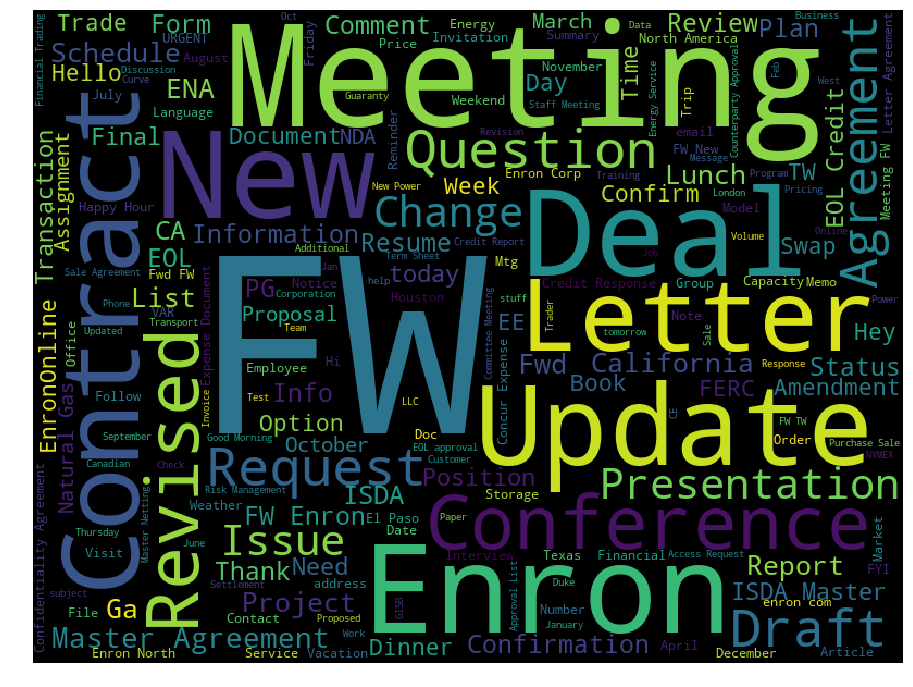

In [316]:
subjects = ' '.join(user_message_df['Subject'])
subjects = subjects.lower()
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)
ax.imshow(wc)
ax.axis("off")

(-0.5, 799.5, 599.5, -0.5)

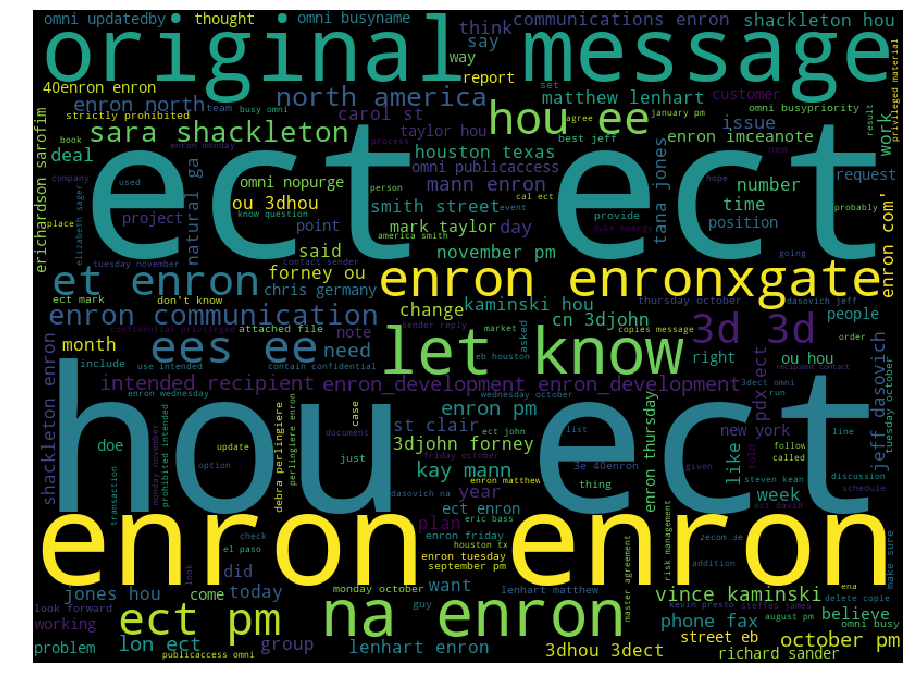

In [321]:
stop_words = set(ENGLISH_STOP_WORDS)
stop_words.add('com')
stop_words.add('http')
stop_words.add('cc')
stop_words.add('sent')
stop_words.add('subject')
stop_words.add('mailto')
stop_words.add('http')
stop_words.add('corp')
#stop_words.add('http')

subjects = ' '.join(user_message_df['content'])
subjects = subjects.lower()
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=stop_words).generate(subjects)
ax.imshow(wc)
ax.axis("off")

(-0.5, 799.5, 599.5, -0.5)

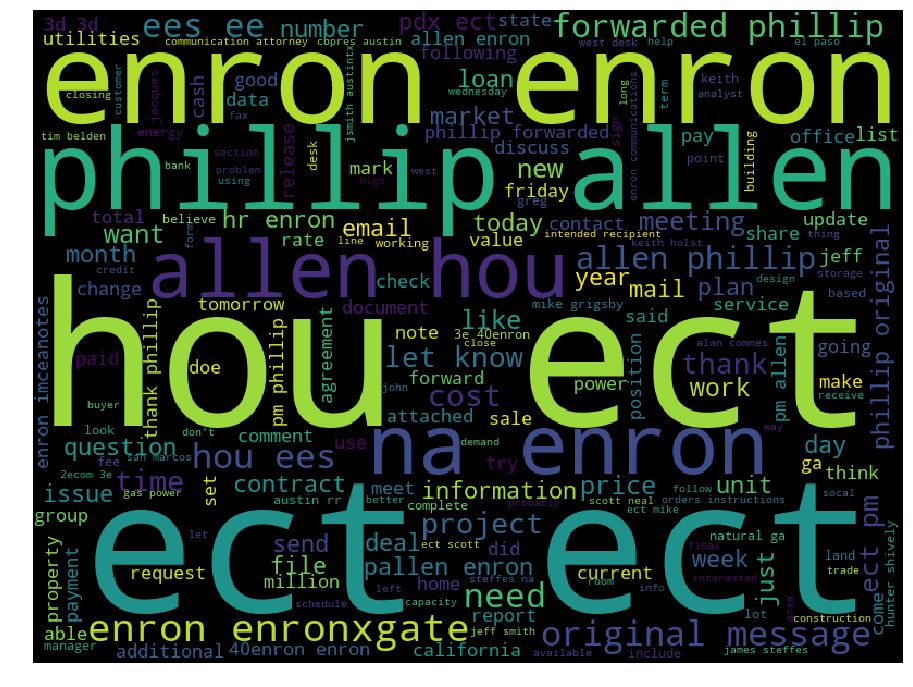

In [352]:
## Word cloud around most central user in email network
subjects = ' '.join(user_message_df[user_message_df['user']=='allen-p']['content'])
subjects = subjects.lower()
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=stop_words).generate(subjects)
ax.imshow(wc)
ax.axis("off")

For topic analysis, please refer topic_analysis.ipynb